In [1]:
# Get the data from Kaggle:
# !kaggle datasets download -d vishalsubbiah/pokemon-images-and-types

# !mkdir -p ../input/pokemon-images-and-types
# !unzip pokemon-images-and-types.zip -d ../input/pokemon-images-and-types

# Explore the data

Read the images and metadata information, and display examples of images.

In [2]:
import os
import pandas as pd

INPUT_DIR = '../input/pokemon-images-and-types'

pokemon = pd.read_csv(os.path.join(INPUT_DIR, 'pokemon.csv'))
pokemon = pokemon.sort_values(by='Name')

display(pokemon.head())
display(pokemon.describe())
display(pokemon['Type1'].unique())

,Name,Type1,Type2
459,abomasnow,Grass,Ice
62,abra,Psychic,NaN
358,absol,Dark,NaN
616,accelgor,Bug,NaN
680,aegislash-blade,Steel,Ghost


,Name,Type1,Type2
count,809,809,405
unique,809,18,18
top,abomasnow,Water,Flying
freq,1,114,95


array(['Grass', 'Psychic', 'Dark', 'Bug', 'Steel', 'Rock', 'Normal',
       'Water', 'Dragon', 'Electric', 'Poison', 'Fire', 'Fairy', 'Ice',
       'Ground', 'Ghost', 'Fighting', 'Flying'], dtype=object)

printing image of cutiefly


(120, 120, 3)

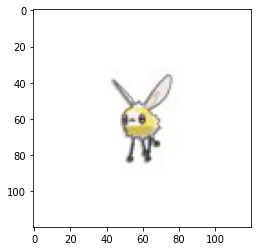

In [3]:
import os
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

def read_img(img_name):
    basename = os.path.basename(img_name)
    
    name, suffix = basename.split('.')
    mdata = matplotlib.image.imread(img_name)
    
    if suffix != 'png':
        mdata = mdata.astype(np.float32) / 255
   
    return (mdata[:,:,:3], name)

mdata, label = read_img(os.path.join(INPUT_DIR, 'images/images/cutiefly.jpg'))

print(f'printing image of {label}')
type(mdata)
display(mdata.shape)
plt.imshow(mdata)

In [4]:
from PIL import Image
import numpy as np
from tensorflow.keras.utils import img_to_array


def read_img(imgname):
    img = Image.open(imgname)
    img = img.convert('RGBA')
    
    basename = os.path.basename(imgname)
    name, suffix = basename.split('.') 

    if suffix == 'png':
        white_bg = Image.new('RGBA', img.size, (255, 255, 255))
        img = Image.alpha_composite(white_bg, img)
    
    mdata = img_to_array(img, dtype='float32')
    mdata = 1.0 - mdata.astype(np.float32) / 255

    return mdata[:, :, :3], name

2022-11-15 07:27:55.610651: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-11-15 07:27:55.610708: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-11-15 07:27:55.649617: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-11-15 07:27:56.297355: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-11-15 07:27:56.297437: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: ca

# Preprocessing Data

Create data preprocessing functions that reads in the following data:

- Label data with "Type1" of pokemon metadata, with OneHotEncoding.
- The image data from JPG and PNG files in the images/images directory.

The output data uses a generator to return `(image_data, label)` tuples, and creates `tf.data.Dataset`.

In [5]:
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder()
type1 = encoder.fit_transform(pokemon['Type1'].values.reshape((-1, 1)))

display(encoder.categories_)
display(len(encoder.categories_[0]))
display(type1)

[array(['Bug', 'Dark', 'Dragon', 'Electric', 'Fairy', 'Fighting', 'Fire',
        'Flying', 'Ghost', 'Grass', 'Ground', 'Ice', 'Normal', 'Poison',
        'Psychic', 'Rock', 'Steel', 'Water'], dtype=object)]

18

<809x18 sparse matrix of type '<class 'numpy.float64'>'
	with 809 stored elements in Compressed Sparse Row format>

In [6]:
def get_type1name(name):
    return pokemon[pokemon['Name'] == name]['Type1'].values[0]

def encode_type(type_name):
    return encoder.transform(type_name).toarray()

def decode_type(type1):
    return encoder.inverse_transform(type1.reshape(1, -1))[0]

print('Type1 of pokemon abomasnow:', get_type1name('abomasnow'))
print('Type1 encoding of Grass:', encode_type([['Grass']]))

Type1 of pokemon abomasnow: Grass
Type1 encoding of Grass: [[0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]


In [7]:
# Create generator for result image data

import os

def gen_train_imgs():
    imglist = os.listdir(os.path.join(INPUT_DIR, 'images/images'))
    
    for i, img in enumerate(imglist):        
        imgdata, name = read_img(os.path.join(INPUT_DIR, 'images/images', img))
        pokemon_type = get_type1name(name)
        
        type_label = encode_type([[pokemon_type]]).reshape(-1)
        yield (imgdata, type_label)

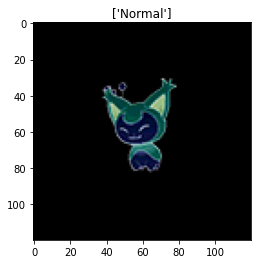

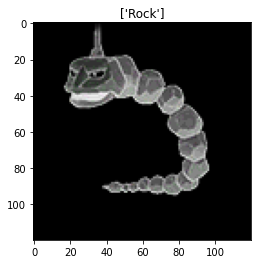

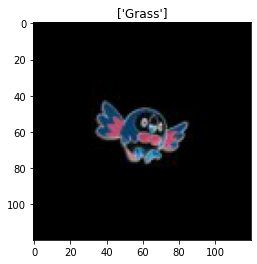

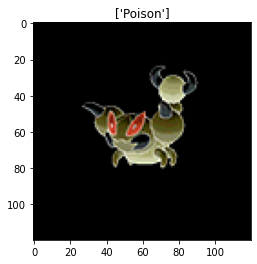

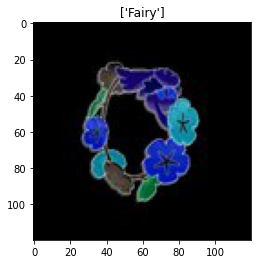

In [8]:
# Test the generator

g = gen_train_imgs()

for i in range(5):
    mdata, label = next(g)
    
    labelname = decode_type(label)
    plt.title(labelname)
    plt.imshow(mdata)
    plt.show()

In [9]:
import tensorflow as tf

dataset = tf.data.Dataset.from_generator(
    gen_train_imgs,
    output_signature=(
        tf.TensorSpec(shape=(120,120,3), dtype=tf.float32),
        tf.TensorSpec(shape=(18,), dtype=tf.int32),
    ),
)

2022-11-15 07:27:57.975601: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-11-15 07:27:57.975631: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2022-11-15 07:27:57.975655: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (c35f0ebe9735): /proc/driver/nvidia/version does not exist


In [10]:
# split the train validation
data_size = pokemon.shape[0]

train_size = int(data_size * 0.8)
val_size = data_size - train_size

print(f'Splitting data size of {data_size} to train: {train_size} and val: {val_size}')
dataset = dataset.shuffle(32)

train_data = dataset.take(train_size).batch(8)
val_data = dataset.skip(train_size).take(val_size).batch(8)

Splitting data size of 809 to train: 647 and val: 162


# Create Tensorflow Model

Create CNN model with Tensorflow Keras library, with Convolutional, Maxpooling layers, and output the result vector the shape of (# of classes).

In [39]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.optimizers import Adam
from keras import regularizers

def build_model():
    model = tf.keras.Sequential([
        Conv2D(32, 3, 3, input_shape=(120, 120, 3), padding='same', activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.2),
        Conv2D(16, 3, 3, padding='same', activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.2),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.2),        
        Dense(32, activation='relu'),
        Dropout(0.2),
        Dense(18, activation='softmax'),
    ])
    model.compile(optimizer=Adam(lr=0.005),
                  loss=tf.keras.losses.CategoricalCrossentropy(),
                  metrics=['accuracy'])
    return model

model = build_model()
model.summary()

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_32 (Conv2D)          (None, 40, 40, 32)        896       
                                                                 
 max_pooling2d_32 (MaxPoolin  (None, 20, 20, 32)       0         
 g2D)                                                            
                                                                 
 dropout_48 (Dropout)        (None, 20, 20, 32)        0         
                                                                 
 conv2d_33 (Conv2D)          (None, 7, 7, 16)          4624      
                                                                 
 max_pooling2d_33 (MaxPoolin  (None, 3, 3, 16)         0         
 g2D)                                                            
                                                                 
 dropout_49 (Dropout)        (None, 3, 3, 16)        

/opt/conda/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [40]:
history = model.fit(
    train_data,
    epochs=40,
    validation_data=val_data,
)

Epoch 1/40
81/81 [==============================] - 5s 60ms/step - loss: 2.8105 - accuracy: 0.1082 - val_loss: 2.7584 - val_accuracy: 0.0988
Epoch 2/40
81/81 [==============================] - 5s 56ms/step - loss: 2.7222 - accuracy: 0.1391 - val_loss: 2.7159 - val_accuracy: 0.1605
Epoch 3/40
81/81 [==============================] - 5s 59ms/step - loss: 2.6737 - accuracy: 0.1546 - val_loss: 2.6172 - val_accuracy: 0.1852
Epoch 4/40
81/81 [==============================] - 5s 60ms/step - loss: 2.6451 - accuracy: 0.1623 - val_loss: 2.6075 - val_accuracy: 0.2160
Epoch 5/40
81/81 [==============================] - 5s 58ms/step - loss: 2.6089 - accuracy: 0.1886 - val_loss: 2.6126 - val_accuracy: 0.1975
Epoch 6/40
81/81 [==============================] - 5s 59ms/step - loss: 2.5555 - accuracy: 0.2087 - val_loss: 2.5259 - val_accuracy: 0.2222
Epoch 7/40
81/81 [==============================] - 4s 54ms/step - loss: 2.5623 - accuracy: 0.2009 - val_loss: 2.5648 - val_accuracy: 0.1790
Epoch 8/40
81

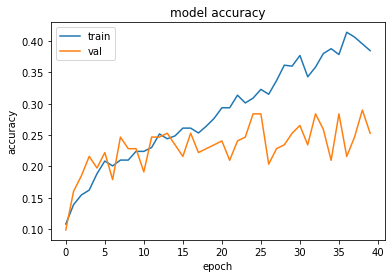

In [41]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()